In [23]:
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import seaborn as sns
import sys
from utils import *

In [24]:
slot = 3  # length of the interval in hours for resampling
look_back = int(7*24/slot)

test_size = 0.2
time_range = (pd.Timestamp(2018, 1, 1), pd.Timestamp(2021, 7, 1))

In [25]:
dataset = select_data('../../../datasets/lease_info/compute_haswell.csv', time_range)
plot_rsrc(dataset, 'compute_haswell')

In [26]:
dataset.shape

(30931, 12)

## Step 1. Resample by a time slot

Counting the number of nodes assigned to Chameleon users within a fixed time interval.

In [27]:
dataset = resample_sum(dataset, slot)
# dataset = get_roll_avg(dataset, rw)
dataset.dropna(inplace=True)
plot_rsrc(dataset, 'compute_haswell')
dataset.set_index(['start_on'], inplace=True)

In [28]:
dataset.shape

(9453, 1)

In [29]:
dataset = dataset.astype(float)
actual_train, actual_test = train_test_split(dataset, test_size=test_size, shuffle=False)

## Step 2. Smooth data

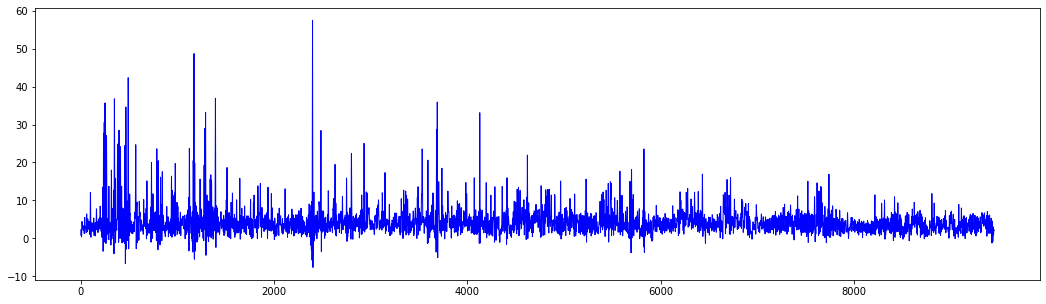

In [30]:
smoother = spectral_smoother(dataset, slot)
# generate intervals
# low, up = smoother.get_intervals('sigma_interval')
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))
plt.plot(smoother.smooth_data.squeeze(), linewidth=1, color='blue')
# plt.fill_between(range(len(smoother.data.squeeze())), low[0], up[0], alpha=0.3)
plt.show()

In [31]:
sd = smoother.smooth_data.squeeze()
dataset['node_cnt'][:sd.shape[0]] = sd

## Step 3. Build LSTM Model

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
import math

In [33]:
# fix random seed for reproducibility
np.random.seed(42)

# data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split training and testing dataset
train, test = train_test_split(dataset, test_size=test_size, shuffle=False)

In [34]:
def create_dataset(ds, lb=1):
    """
    :param ds: a numpy array that you want to convert into a dataset
    :param lb: the number of previous time steps to use as input variables to predict the next time period
    :return: x, y for training LSTM
    """
    data_x, data_y = [], []
    for i in range(len(ds) - lb - 1):
        a = ds[i:(i + lb), 0]
        data_x.append(a)
        data_y.append(ds[i + lb, 0])
    return np.array(data_x), np.array(data_y)

In [35]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [36]:
def loss_function(y_true, y_pred):
    alph = 0.5
    loss = tf.exp(tf.cast(tf.where(y_pred<y_true, 1/alph, -1/alph), tf.float32)) * tf.abs(y_pred - y_true)
    return loss

In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='tanh'))
model.add(Dense(slot))

model.compile(loss=loss_function, optimizer='adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=1, validation_split=0.2, callbacks=[es])
model.save('forecaster.h5')

Epoch 1/30
6004/6004 [==============================] - 21s 3ms/step - loss: 0.0452 - val_loss: 0.0160
Epoch 2/30
6004/6004 [==============================] - 20s 3ms/step - loss: 0.0245 - val_loss: 0.0174
Epoch 3/30
6004/6004 [==============================] - 15s 3ms/step - loss: 0.0177 - val_loss: 0.0107
Epoch 4/30
6004/6004 [==============================] - 16s 3ms/step - loss: 0.0145 - val_loss: 0.0097
Epoch 5/30
6004/6004 [==============================] - 13s 2ms/step - loss: 0.0127 - val_loss: 0.0051
Epoch 6/30
6004/6004 [==============================] - 13s 2ms/step - loss: 0.0119 - val_loss: 0.0183
Epoch 7/30
6004/6004 [==============================] - 14s 2ms/step - loss: 0.0113 - val_loss: 0.0082
Epoch 8/30
6004/6004 [==============================] - 17s 3ms/step - loss: 0.0106 - val_loss: 0.0149
Epoch 9/30
6004/6004 [==============================] - 15s 2ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 10/30
6004/6004 [==============================] - 18s 3ms/step - l

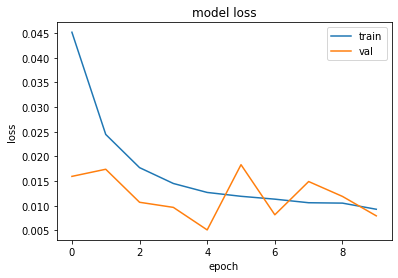

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [39]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.01 RMSE
Test Score: 3.64 RMSE


In [40]:
df = pd.DataFrame([])
df['start_on'] = actual_test.index[look_back+1:]
df.set_index(['start_on'], inplace=True)
df['forecast'] = testPredict.squeeze()
df['smooth'] = testY.squeeze()
df['actual'] = actual_test['node_cnt'].to_list()[look_back+1:]
plot_trace(df, ['forecast', 'actual', 'smooth'])

ValueError: Wrong number of items passed 3, placement implies 1

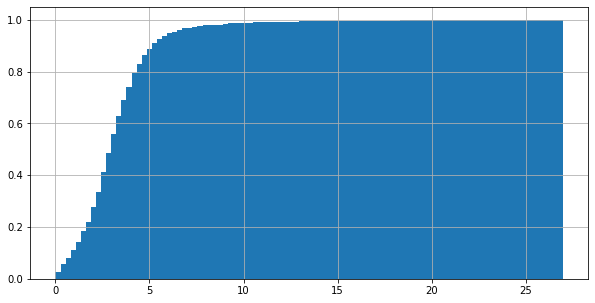

In [19]:
df['AE'] = abs(df['forecast'] - df['actual'])
df['AE'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))
plt.show()

In [20]:
ae = df['AE'].to_frame()
plot_trace(ae, ['AE'])

array([[<AxesSubplot:title={'center':'difference'}>]], dtype=object)

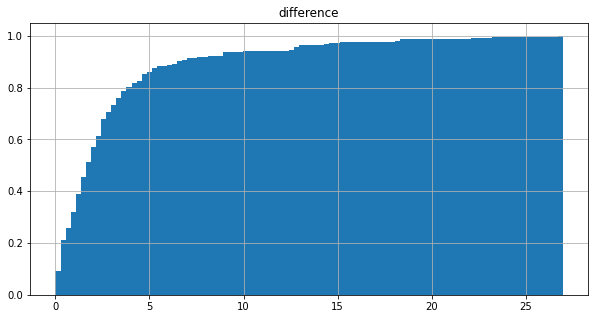

In [21]:
temp = (df['actual']-df['forecast']).to_frame()
temp.columns = ['difference']
temp[temp['difference'] > 0].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))

In [22]:
100*temp[temp['difference'] > 0].shape[0]/df.shape[0]

12.213740458015268